# Preparation

<b>Load Libraries</b>

In [5]:
# src
import os, sys
cwd = os.getcwd()
os.chdir('../../..')
path_to_src = os.getcwd()
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
os.chdir(cwd)
from src.jupyter.support import *

# hyper-parameters tuning
import optuna

# others
from sklearn.preprocessing import TargetEncoder
from warnings import simplefilter
import cloudpickle

<b>Load Libraries</b>

In [6]:
# dataset
materials = prepare_data_to_train('../../../resource/data/cleaned.csv')

<b>MLflow</b>

In [7]:
# connect to local mlflow
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
##
experiment_name = 'Model Engineering'
try:
    mlflow.create_experiment(name=experiment_name, artifact_location='resource/mlflow/runs')
except:
    mlflow.set_experiment(experiment_name=experiment_name)

<b>UDC</b>

In [8]:
# udc: auto detect category
class UDC_Transformers(FSBaseTransformer):
    def fit(self, X: np.ndarray, y: np.ndarray=None):
        X, idxes = self.detect_category(X)
        ##
        self.assigned_transformers = [('ohe', OneHotEncoder(drop='first', sparse_output=False), idxes['cat']), 
                                      ('qtt', QuantileTransformer(output_distribution='normal'), idxes['num'])]
        
        super().fit(X, y)

        return self

# Evaluation

<b>Hyper-parameters Tuning</b>

In [10]:
# warnings
simplefilter(action='ignore')
 
# feature selector
path_to_sfs = mlflow.artifacts.download_artifacts(f'runs:/1eb663989aa049b089d19baff26658c7/model/sfs.pkl')
with open(path_to_sfs, 'rb') as f:
    sfs = cloudpickle.load(f)
    idxes_to_choose = list(sfs.k_feature_idx_)
feature_selector = FunctionTransformer(lambda X, idxes: X[:, idxes], kw_args={'idxes': idxes_to_choose})

# transformers
transfomers = UDC_Transformers()

# study
study = optuna.create_study(direction='maximize')

# objective function
def objective(trial: optuna.Trial):
    ##
    params = dict()
    params['num_leaves'] = trial.suggest_int('num_leaves', low=31, high=100)
    params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', low=20, high=100)
    params['max_depth'] = trial.suggest_int('max_depth', low=1, high=10)
    params['max_bin'] = trial.suggest_int('max_bin', low=50, high=255)
    params['bagging_fraction'] = trial.suggest_float('bagging_fraction', low=0.1, high=1.0)
    params['bagging_freq'] = trial.suggest_int('bagging_freq', low=1, high=10)
    params['feature_fraction'] = trial.suggest_float('feature_fraction', low=0.1, high=1.0)
    ##
    lgbm = LGBMClassifier(n_jobs=-1, verbose=-1, **params)
    pipeline = Pipeline([('fs', feature_selector), ('trans', transfomers), ('LGBM', lgbm)])
    cv_results = cross_val_score(pipeline, materials['X_train'], materials['y_train'], 
                                 scoring=make_scorer(fbeta_score, beta=2), 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3))
    
    return cv_results.mean()

# evaluation
study.optimize(func=objective, n_trials=100)

[I 2024-08-29 14:50:53,939] A new study created in memory with name: no-name-809039fc-43df-406a-85d5-ca626578274f


[I 2024-08-29 14:50:58,598] Trial 0 finished with value: 0.6968291643325426 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 53, 'max_depth': 7, 'max_bin': 227, 'bagging_fraction': 0.8918712033984872, 'bagging_freq': 4, 'feature_fraction': 0.45422451493907945}. Best is trial 0 with value: 0.6968291643325426.
[I 2024-08-29 14:51:02,576] Trial 1 finished with value: 0.641018072773375 and parameters: {'num_leaves': 37, 'min_data_in_leaf': 91, 'max_depth': 8, 'max_bin': 149, 'bagging_fraction': 0.3651140145861207, 'bagging_freq': 9, 'feature_fraction': 0.695637619799673}. Best is trial 0 with value: 0.6968291643325426.
[I 2024-08-29 14:51:06,506] Trial 2 finished with value: 0.7824882158583809 and parameters: {'num_leaves': 33, 'min_data_in_leaf': 26, 'max_depth': 4, 'max_bin': 238, 'bagging_fraction': 0.6527044625692516, 'bagging_freq': 3, 'feature_fraction': 0.6878148050248795}. Best is trial 2 with value: 0.7824882158583809.
[I 2024-08-29 14:51:10,471] Trial 3 finished with value:

<b>Logging</b>

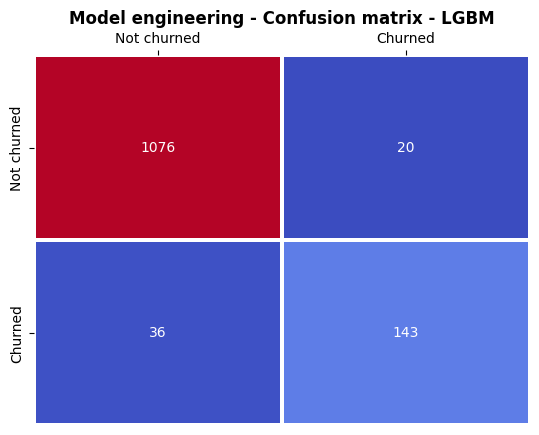

In [11]:
lgbm = LGBMClassifier(n_jobs=-1, verbose=-1, **study.best_params)
pipeline = Pipeline([('fs', feature_selector), ('trans', transfomers), 
                     ('ros', RandomOverSampler()), ('LGBM', lgbm)])
pipeline.fit(materials['X_train'], materials['y_train'])
val_predictions = pipeline.predict(materials['X_test'])
val_fbeta = fbeta_score(materials['y_test'], val_predictions, beta=2)

conf_mat = confusion_matrix(materials['y_test'], val_predictions)
fig, ax = plt.subplots()
g = sns.heatmap(conf_mat, annot=True, fmt='.0f', 
                cmap='coolwarm', cbar=False, linewidths=1.5, ax=ax)
g.xaxis.tick_top()
g.set_xticklabels(['Not churned', 'Churned'])
g.set_yticklabels(['Not churned', 'Churned'])
g.set_title('Model engineering - Confusion matrix - LGBM', 
            fontdict=dict(weight='bold'))
fig.savefig('../../../resource/jupyter/temp/me_conf_mat.png')

plt.show()

In [14]:
with mlflow.start_run(): 
    ## 
    mlflow.set_tags({'pre_pro': 'ohe_qtt_fs_hyopt_ros', 'base_model': 'LGBM', 
                     'beta_f': 2})
    ##
    mlflow.log_metrics({'avg_fbeta': study.best_trial.values[0], 
                        'val_fbeta': val_fbeta})
    ##
    mlflow.log_artifact(local_path='../../../resource/jupyter/temp/me_conf_mat.png', 
                        artifact_path='model')
    ##
    mlflow.log_params(study.best_params)
    ##
    mlflow.sklearn.log_model(sk_model=pipeline, artifact_path='model')